In [3]:
#goal: determine a configuration of n queens on an nxn chessboard st no queen can be taken by another
#each queen is assigned to a column + only one queen per line

import random
from deap import base
from deap import creator
from deap import tools

#define fitness objective and individual classes
#want to minimize objective (objective = number of conflicts)

#problem parameter
n = 20

creator.create("FitnessMax", base.Fitness, weights = (-1.0,))
creator.create("IndividualQueen", list, fitness = creator.FitnessMax)

#define toolbox
#.sample(tuple, number) prints #number# of the tuple elements in a random element
toolbox_q = base.Toolbox()
toolbox_q.register("permutation", random.sample, range(n), n)

#Create structure
#Individual: list that represents position of each queen
#line is stored, column = index of number in list
toolbox_q.register("individual", tools.initIterate, creator.IndividualQueen, toolbox_q.permutation)
toolbox_q.register("population", tools.initRepeat, list, toolbox_q.individual)
#ex: n = 10. Individual:[7,0,4,6,5,1,9,2,8,3]. 1st integer in list = 7; queen on 1st row is in 7+1= 8th column

#create evaluation functions
#counts the number of conflicts with other queens.
#because there is by default only one queen per row and column, conflicts only occur on the diagonal
def evalNQueens(individual):
    size = len(individual)
    left_diagonal = [0] * (2 * size - 1)
    right_diagonal = [0] *(2 * size - 1)
    #sum number of queens on each diagonal
    for i in range(size):
        left_diagonal[i+individual[i]] += 1
        right_diagonal[size-1-i + individual[i]] += 1
    #Count number of conflicts on each diagonal
    sum_ = 0
    for i in range(2 * size - 1):
        if left_diagonal[i] > 1:
            sum_ += left_diagonal[i] - 1
        if right_diagonal[i] > 1:
            sum_ += right_diagonal[i] - 1
    return sum_,

#Create a partially matched crossover on input individuals, and modify it in place
#returns tuple of individuals generated by matching pairs of values in a range and swapping the values
def cxPartiallyMatched(ind1, ind2):
    size = min(len(ind1), len(ind2))
    p1, p2 = [0] * size, [0] * size
    #initialize positio nof indices in the individuals
    for i in range(size):
        p1[ind1[i]] = i
        p2[ind2[i]] = i
    #Choose crossover point; if point 2 < point 1, swap points
    cxpoint1 = random.randint(0,size)
    cxpoint2 = random.randint(0, size - 1)
    if cxpoint2 >= cxpoint1:
        cxpoint2 += 1
    else:
        cxpoint1, cxpoint2 = cxpoint2, cxpoint1
    
    #Apply crossover between points
    for i in range (cxpoint1, cxpoint2):
        #keep track of selected values
        temp1 = ind1[i]
        temp2 = ind2[i]
        # Swap matched value
        ind1[i], ind1[p1[temp2]] = temp2, temp1
        ind2[i], ind2[p2[temp1]] = temp1, temp2
        #Change position array
        p1[temp1], p2[temp2] = p1[temp2], p1[temp1]
        p2[temp1], p2[temp2] = p2[temp2], p2[temp1]
    return ind1, ind2

#Two point crossover on given input, not ideal for this problem because
#information gained from parentst
def cxTwoPoint(ind1, ind2):
    size = min(len(ind1), len(ind2))
    cxpoint1 = random.randint(1, size)
    cxpoint2 = random.randint(1, size - 1)
    if (cxpoint2 >= cxpoint1):
        cxpoint2+= 1
    else:
        cxpoint1, cxpoint2 = cxpoint2, cxpoint1
    ind1[cxpoint1:cxpoint2], ind2[cxpoint1:cxpoint2] = ind2[cxpoint1:cxpoint2], ind1[cxpoint1:cxpoint2]
    return ind1, ind2

#mutation function - shuffle attributes of input
#indpb - independent probability of attribute being changed
def mutShuffleIndexes(individual, indpb):
    size = len(individual)
    for i in range (size):
        if random.random() < indpb:
            swap_indx = random.randint(0, size - 2)
            if swap_indx >= i:
                swap_indx +=1
            individual[i], individual[swap_indx] = individual[swap_indx], individual[i]
    return individual

#My own mutation function:
def myMut(individual, indpb):
    size = len(individual)
    for i in range (size):
        swap_dex = random.randint(0, size - 1)
        individual[i], individual[swap_dex] = individual[swap_dex], individual[i]
        

toolbox_q.register("evaluate", evalNQueens)
toolbox_q.register("mate", cxPartiallyMatched)
toolbox_q.register("mutate", mutShuffleIndexes, indpb =2.0/n)
toolbox_q.register("select", tools.selTournament, tournsize=3)

#main evolutionary loop
pop = toolbox_q.population(n = 300)
#evaluate population
fitnesses = list(map(toolbox_q.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit
for g in range(100):
    print("-- Generation %i --" % g)
    #select next generation individuals
    offspring = toolbox_q.select(pop, len(pop))
    offspring = list(map(toolbox_q.clone, offspring))
    
    #apply crossover and  mutation
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        #50% change to mate
        if random.random() < 0.5:
            toolbox_q.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values
        
    for mutant in offspring:
        if random.random() < 0.2:
            toolbox_q.mutate(mutant)
            del mutant.fitness.values
        
    #evaluate individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox_q.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Replace population
    pop[:] = offspring

    # Gather all the fitnesses in one list and print the stats
    fits = [ind.fitness.values[0] for ind in pop]

    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x*x for x in fits)
    std = abs(sum2 / length - mean**2)**0.5

    print("  Min %s" % min(fits))
    print("  Max %s" % max(fits))
    print("  Avg %s" % mean)
    print("  Std %s" % std)

print("-- End of (successful) evolution --")

best_ind = tools.selBest(pop, 1)[0]
print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))


    



C:\Users\avnit\Anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\Users\avnit\Anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'IndividualQueen' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


-- Generation 0 --
  Min 5.0
  Max 14.0
  Avg 9.286666666666667
  Std 1.714007649405983
-- Generation 1 --
  Min 5.0
  Max 14.0
  Avg 8.573333333333334
  Std 1.7938660918684912
-- Generation 2 --
  Min 4.0
  Max 13.0
  Avg 8.07
  Std 1.9179242251281245
-- Generation 3 --
  Min 5.0
  Max 15.0
  Avg 7.76
  Std 2.005592181875467
-- Generation 4 --
  Min 4.0
  Max 15.0
  Avg 7.706666666666667
  Std 2.0929936030055645
-- Generation 5 --
  Min 2.0
  Max 16.0
  Avg 7.59
  Std 2.2215385059308193
-- Generation 6 --
  Min 2.0
  Max 14.0
  Avg 7.426666666666667
  Std 2.0955402379550927
-- Generation 7 --
  Min 2.0
  Max 14.0
  Avg 7.466666666666667
  Std 2.2514193054357703
-- Generation 8 --
  Min 3.0
  Max 13.0
  Avg 7.04
  Std 2.1920462282229973
-- Generation 9 --
  Min 2.0
  Max 14.0
  Avg 6.803333333333334
  Std 2.308965617375499
-- Generation 10 --
  Min 2.0
  Max 14.0
  Avg 6.673333333333333
  Std 2.5987090812341607
-- Generation 11 --
  Min 2.0
  Max 13.0
  Avg 6.153333333333333
  Std 2.46

-- Generation 0 --
  Min 4.0
  Max 15.0
  Avg 9.133333333333333
  Std 1.968643074697789
-- Generation 1 --
  Min 3.0
  Max 14.0
  Avg 8.343333333333334
  Std 2.07013418781381
-- Generation 2 --
  Min 3.0
  Max 14.0
  Avg 7.8933333333333335
  Std 2.091719122848211
-- Generation 3 --
  Min 3.0
  Max 14.0
  Avg 7.803333333333334
  Std 2.2055964171977482
-- Generation 4 --
  Min 3.0
  Max 14.0
  Avg 7.496666666666667
  Std 2.3173236478508743
-- Generation 5 --
  Min 3.0
  Max 16.0
  Avg 7.233333333333333
  Std 2.395597814510793
-- Generation 6 --
  Min 3.0
  Max 14.0
  Avg 7.07
  Std 2.3646916641851354
-- Generation 7 --
  Min 3.0
  Max 16.0
  Avg 6.576666666666667
  Std 2.4557664565037283
-- Generation 8 --
  Min 3.0
  Max 13.0
  Avg 6.486666666666666
  Std 2.5409621974537306
-- Generation 9 --
  Min 3.0
  Max 15.0
  Avg 6.046666666666667
  Std 2.5905898084327355
-- Generation 10 --
  Min 2.0
  Max 16.0
  Avg 5.8533333333333335
  Std 2.873758669215091
-- Generation 11 --
  Min 2.0
  Max 1

  Min 0.0
  Max 8.0
  Avg 0.93
  Std 2.065211853539486
-- Generation 98 --
  Min 0.0
  Max 10.0
  Avg 0.7633333333333333
  Std 1.8940227618015106
-- Generation 99 --
  Min 0.0
  Max 11.0
  Avg 0.7266666666666667
  Std 1.9660337964767771
-- End of (successful) evolution --
Best individual is [17, 15, 12, 9, 2, 5, 3, 14, 7, 4, 13, 0, 8, 18, 16, 19, 6, 11, 1, 10], (0.0,)


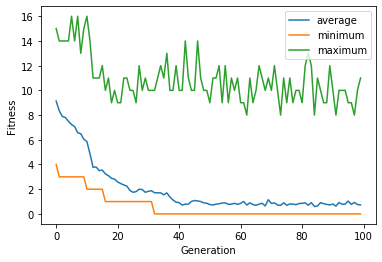

In [4]:
#create list of statistics
gen = range(100)
avg_list = []
max_list = []
min_list = []

pop = toolbox_q.population(n=300)

# Evaluate the  population
fitnesses = list(map(toolbox_q.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

# Begin  evolution
for g in gen:
    print("-- Generation %i --" % g)

    # Select the next generation individuals
    offspring = toolbox_q.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox_q.clone, offspring))

    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < 0.5:
            toolbox_q.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < 0.2:
            toolbox_q.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox_q.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Replace population
    pop[:] = offspring

    # Gather all the fitnesses in one list and print the stats
    fits = [ind.fitness.values[0] for ind in pop]

    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x*x for x in fits)
    std = abs(sum2 / length - mean**2)**0.5
    g_max = max(fits)
    g_min = min(fits)
        
    avg_list.append(mean)
    max_list.append(g_max)
    min_list.append(g_min)

    print("  Min %s" % g_min)
    print("  Max %s" % g_max)
    print("  Avg %s" % mean)
    print("  Std %s" % std)

print("-- End of (successful) evolution --")

best_ind = tools.selBest(pop, 1)[0]
print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))
    
import matplotlib.pyplot as plt
plt.plot(gen, avg_list, label="average")
plt.plot(gen, min_list, label="minimum")
plt.plot(gen, max_list, label="maximum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="upper right")
plt.show()